In [1]:
pip install torch numpy pandas scikit-learn tensorflow shap scikit-optimize openpyxl numpy matplotlib scikit-learn scipy tensorflow boruta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.4 MB/s eta 0:00:00


In [2]:
from BTC_helper import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap

In [12]:
def prepare_data(df, model_type):
    # Separate the dependent and independent variables
    X = df.drop('price_inconsistency', axis=1)
    y = df['price_inconsistency']

    # Split the data into training + validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Then split the training + validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the training data
    scaler.fit(X_train)

    # Transform the training, validation, and test data
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input data to fit the CNN-BiLSTM model (samples, time steps, features)
    if model_type == 'CNN-BiLSTM':
        X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_val_scaled = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
        X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


def load_date_to_index(file_path):
    df = pd.read_csv(file_path) # Load the csv file
    df['Date'] = pd.to_datetime(df['Date']) # Convert the 'Date' column to datetime format
    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)
    return df

# Load the preprocessed csv files
kraken_data_encoded_reduced_smooth = pd.read_csv("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = pd.read_csv("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = pd.read_csv("binance_data_encoded_reduced_smooth.csv")

# Load and prepare the data
kraken_data_encoded_reduced_smooth = load_date_to_index("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = load_date_to_index("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = load_date_to_index("binance_data_encoded_reduced_smooth.csv")

# Prepare the data
model_type="CNN-BiLSTM" # "" if 2D shape is required
kraken_X_train_scaled, kraken_X_val_scaled, kraken_X_test_scaled, kraken_y_train, kraken_y_val, kraken_y_test = prepare_data(kraken_data_encoded_reduced_smooth,model_type)
coinbase_X_train_scaled, coinbase_X_val_scaled, coinbase_X_test_scaled, coinbase_y_train, coinbase_y_val, coinbase_y_test = prepare_data(coinbase_data_encoded_reduced_smooth,model_type)
binance_X_train_scaled, binance_X_val_scaled, binance_X_test_scaled, binance_y_train, binance_y_val, binance_y_test = prepare_data(binance_data_encoded_reduced_smooth,model_type)

print("Kraken data")
print(kraken_X_train_scaled.shape)
print(kraken_X_val_scaled.shape)
print(kraken_X_test_scaled.shape)

print("")
print("Coinbase data")
print(coinbase_X_train_scaled.shape)
print(coinbase_X_val_scaled.shape)
print(coinbase_X_test_scaled.shape)

print("")
print("Binance data")
print(binance_X_train_scaled.shape)
print(binance_X_val_scaled.shape)
print(binance_X_test_scaled.shape)


Kraken data
(6873, 1, 22)
(2291, 1, 22)
(2291, 1, 22)

Coinbase data
(5486, 1, 22)
(1829, 1, 22)
(1829, 1, 22)

Binance data
(6902, 1, 22)
(2301, 1, 22)
(2301, 1, 22)


In [4]:
#print(binance_data_encoded_reduced_smooth)
binance_data_encoded_reduced_smooth.columns

Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP'],
      dtype='object')

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap
from functools import partial
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Custom Dataset class to work with PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create custom PyTorch model
class CNNBiLSTM(nn.Module):
    def __init__(self, input_size, conv_filters, lstm_units, dense_units, dropout_rate):
        super(CNNBiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, conv_filters, kernel_size=input_size, padding=0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm = nn.LSTM(conv_filters, lstm_units, bidirectional=True, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2*lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)  # Transpose the dimensions to make the output compatible with LSTM
        x, _ = self.bilstm(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the search space for hyperparameters
search_space = [Integer(32, 128, name='conv_filters'),
                Integer(32, 128, name='lstm_units'),
                Integer(16, 64, name='dense_units'),
                Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'),
                Real(0.1, 0.5, name='dropout_rate'),
                Integer(8, 64, name='batch_size'),
                Real(1e-6, 1e-1, prior='log-uniform', name='l2_reg')]


def train_evaluate_model(params, X_train_scaled, y_train, X_val_scaled, y_val):
    print(f"Current params: {params}")  # Add this line to print the params list
    conv_filters = params[0]
    lstm_units = params[1]
    dense_units = params[2]
    learning_rate = params[3]
    dropout_rate = params[4]
    batch_size = int(params[5])  # Convert batch_size to an integer
    l2_reg=params[6]

    model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)

    criterion = nn.MSELoss()
    optimizer = optim.Adamax(model.parameters(), lr=learning_rate,weight_decay=l2_reg)
    
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TimeSeriesDataset(X_val_scaled, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Train the model
    epochs = 5
    patience = 4
    min_val_loss = np.inf
    counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}')

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            break

    return val_loss



Optimizing hyperparameters for kraken exchange...
Current params: [89, 113, 57, 0.004948840736375756, 0.349425478714389, 30, 3.073781785362612e-05]
Epoch: 1/5, Training Loss: 17.0127, Validation Loss: 94.5282
Epoch: 2/5, Training Loss: 9.9955, Validation Loss: 74.6721
Epoch: 3/5, Training Loss: 9.6992, Validation Loss: 43.9034
Epoch: 4/5, Training Loss: 9.4815, Validation Loss: 29.3833
Epoch: 5/5, Training Loss: 9.5083, Validation Loss: 22.3005
Current params: [37, 58, 39, 0.004210536704211823, 0.291990868950023, 30, 0.015149343663386152]
Epoch: 1/5, Training Loss: 22.3072, Validation Loss: 27.7117
Epoch: 2/5, Training Loss: 13.1953, Validation Loss: 109.5098
Epoch: 3/5, Training Loss: 11.1809, Validation Loss: 53.4353
Epoch: 4/5, Training Loss: 10.8735, Validation Loss: 87.4993
Epoch: 5/5, Training Loss: 10.5592, Validation Loss: 26.3854
Current params: [64, 94, 34, 0.008209379223637906, 0.15614031216505808, 57, 0.000233367420799604]
Epoch: 1/5, Training Loss: 16.4282, Validation Loss

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 1/5, Training Loss: 33.2548, Validation Loss: 28.3820
Epoch: 2/5, Training Loss: 30.8583, Validation Loss: 21.5019
Epoch: 3/5, Training Loss: 27.1773, Validation Loss: 13.8872
Epoch: 4/5, Training Loss: 25.6347, Validation Loss: 12.1073
Epoch: 5/5, Training Loss: 25.4352, Validation Loss: 11.6637
Current params: [63, 36, 46, 0.008277487569782088, 0.3611161268021964, 44, 0.09473224693917257]
Epoch: 1/5, Training Loss: 20.8141, Validation Loss: 12.6353
Epoch: 2/5, Training Loss: 10.6756, Validation Loss: 26.0693
Epoch: 3/5, Training Loss: 8.5856, Validation Loss: 23.5272
Epoch: 4/5, Training Loss: 9.1965, Validation Loss: 24.5189
Epoch: 5/5, Training Loss: 8.5409, Validation Loss: 45.8894
Current params: [88, 72, 39, 0.0017661199741399731, 0.23520304593555674, 46, 3.854860890182695e-05]
Epoch: 1/5, Training Loss: 25.7000, Validation Loss: 8.6757
Epoch: 2/5, Training Loss: 15.7605, Validation Loss: 18.1482
Epoch: 3/5, Training Loss: 10.6110, Validation Loss: 43.4240
Epoch: 4/5, Tra

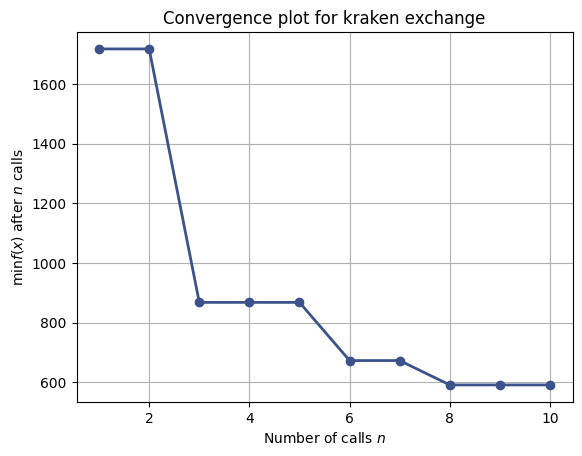

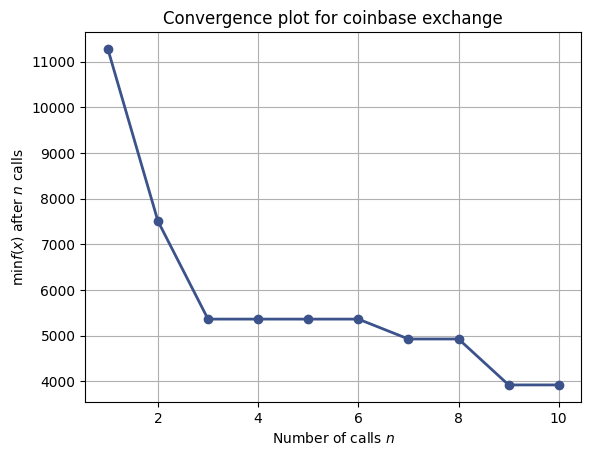

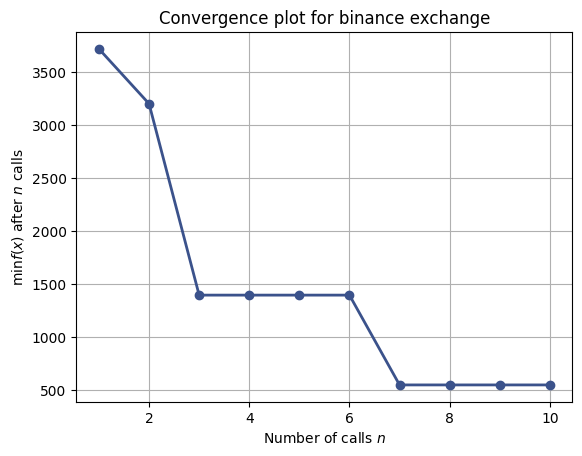

In [39]:
import numpy as np
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt import gp_minimize
import matplotlib.pyplot as plt

# Create a dictionary to store the optimal hyperparameters for each exchange
optimal_params = {}

for exchange in ['kraken', 'coinbase', 'binance']:
    print(f"Optimizing hyperparameters for {exchange} exchange...")

    # Load the data
    X_train_scaled = globals()[f'{exchange}_X_train_scaled']
    y_train = globals()[f'{exchange}_y_train']
    X_val_scaled = globals()[f'{exchange}_X_val_scaled']
    y_val = globals()[f'{exchange}_y_val']

    # Define the objective function for optimization
    @use_named_args(search_space)
    def objective(**params):
        return train_evaluate_model(list(params.values()), X_train_scaled, y_train, X_val_scaled, y_val)

    # Run the optimization
    res_gp = gp_minimize(objective, search_space, n_calls=10, random_state=0)

    # Store the optimal hyperparameters
    optimal_params[exchange] = res_gp.x

    # Plot the convergence
    plt.figure()
    plot_convergence(res_gp)
    plt.title(f'Convergence plot for {exchange} exchange')
    plt.savefig(f'{exchange}_convergence.png', dpi=300)

# Save the optimal hyperparameters
np.save('optimal_params.npy', optimal_params)


In [48]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

# Load the optimal hyperparameters
optimal_params = np.load('optimal_params.npy', allow_pickle=True).item()

import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

import matplotlib.pyplot as plt

def train_evaluate_model_final(params, X_train_scaled, y_train, X_test_scaled, y_test):
    print(len(params))

    conv_filters = params[0]
    lstm_units = params[1]
    dense_units = params[2]
    learning_rate = params[3]
    dropout_rate = params[4]
    batch_size = int(params[5])  # Convert batch_size to an integer
    l2_reg = params[6]

    model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

    train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    epochs = 100
    patience = 10
    best_loss = float('inf')
    no_improvement_count = 0
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Evaluate the model on the test data
        test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_predictions = model(batch_X)
                test_loss += criterion(batch_predictions.squeeze(), batch_y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}')

        # Check for early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print('Early stopping')
            break

    # Evaluate the model on the training data
    model.eval()
    train_predictions = []
    with torch.no_grad():
        for batch_X, _ in train_loader:
            batch_predictions = model(batch_X)
            train_predictions.extend(batch_predictions.numpy())
    train_rmse = sqrt(mean_squared_error(y_train, train_predictions))

    # Evaluate the model on the test data
    test_predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_predictions = model(batch_X)
            test_predictions.extend(batch_predictions.numpy())
    test_rmse = sqrt(mean_squared_error(y_test, test_predictions))

    print(f'Final Train RMSE: {train_rmse:.6f} | Final Test RMSE: {test_rmse:.6f}')
    
    # Plot the training and testing loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')

    # Plot the predicted and true values
    # Convert lists to numpy arrays
    test_predictions = np.array(test_predictions)
    y_test = np.array(y_test)

    # Create a range of indices
    x_range = np.arange(len(y_test))

    
    plt.figure(figsize=(10,5))
    plt.plot(x_range, y_test, label='True Values')
    plt.plot(x_range, test_predictions, label='Predicted Values')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()


def train_for_exchange(exchange):
    print(f"Training model for {exchange} exchange...")

    # Load the data
    X_train_scaled = globals()[f'{exchange}_X_train_scaled']
    y_train = globals()[f'{exchange}_y_train']
    X_test_scaled = globals()[f'{exchange}_X_test_scaled']
    y_test = globals()[f'{exchange}_y_test']

    # Get the optimal hyperparameters for this exchange
    params = optimal_params[exchange]

    # Train and evaluate the model
    train_evaluate_model_final(params, X_train_scaled, y_train, X_test_scaled, y_test)




Training model for kraken exchange...
7
Epoch: 1/100
Train Loss: 16.967398 | Test Loss: 139.520377
Epoch: 2/100
Train Loss: 11.400531 | Test Loss: 51.227374
Epoch: 3/100
Train Loss: 11.564253 | Test Loss: 3.722900
Epoch: 4/100
Train Loss: 10.311861 | Test Loss: 15.820797
Epoch: 5/100
Train Loss: 11.180401 | Test Loss: 8.158660
Epoch: 6/100
Train Loss: 10.278586 | Test Loss: 11.460793
Epoch: 7/100
Train Loss: 10.197091 | Test Loss: 8.651656
Epoch: 8/100
Train Loss: 10.413830 | Test Loss: 8.226175
Epoch: 9/100
Train Loss: 10.587098 | Test Loss: 1.327309
Epoch: 10/100
Train Loss: 10.256819 | Test Loss: 5.637584
Epoch: 11/100
Train Loss: 10.432252 | Test Loss: 1.429730
Epoch: 12/100
Train Loss: 10.879829 | Test Loss: 3.125313
Epoch: 13/100
Train Loss: 10.111188 | Test Loss: 10.413395
Epoch: 14/100
Train Loss: 11.045773 | Test Loss: 9.755357
Epoch: 15/100
Train Loss: 10.197133 | Test Loss: 8.661957
Epoch: 16/100
Train Loss: 10.657288 | Test Loss: 4.066076
Epoch: 17/100
Train Loss: 9.900306 

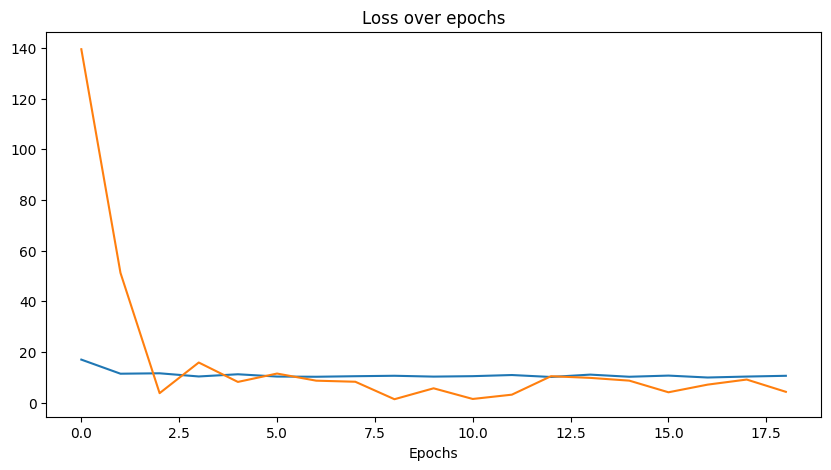

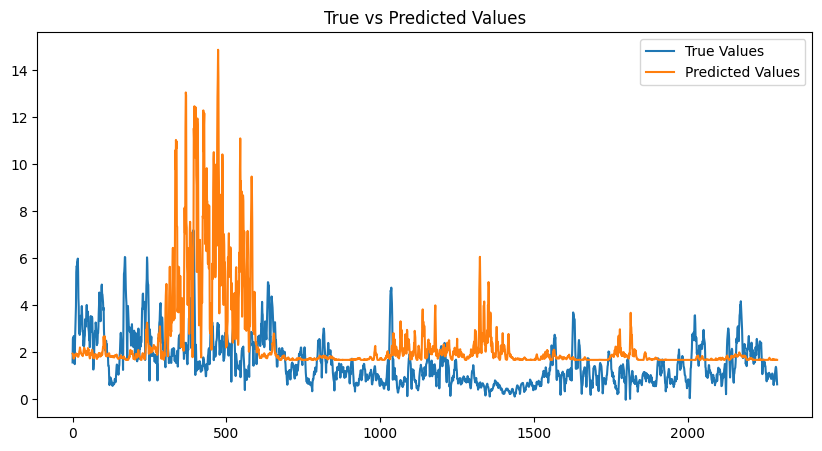

In [49]:
# Exchange for which model needs to be trained
exchange = 'kraken'  # Change this to 'coinbase' or 'binance' as needed

# Train the model for the specific exchange
train_for_exchange(exchange)

Training model for coinbase exchange...
7
Epoch: 1/100
Train Loss: 21.555824 | Test Loss: 76.433653
Epoch: 2/100
Train Loss: 7.718135 | Test Loss: 119.238881
Epoch: 3/100
Train Loss: 7.421476 | Test Loss: 91.846638
Epoch: 4/100
Train Loss: 6.828942 | Test Loss: 118.085074
Epoch: 5/100
Train Loss: 6.585849 | Test Loss: 141.035970
Epoch: 6/100
Train Loss: 6.468109 | Test Loss: 99.491137
Epoch: 7/100
Train Loss: 5.898366 | Test Loss: 123.143413
Epoch: 8/100
Train Loss: 5.971431 | Test Loss: 97.667677
Epoch: 9/100
Train Loss: 5.936960 | Test Loss: 109.689983
Epoch: 10/100
Train Loss: 6.254812 | Test Loss: 120.355225
Epoch: 11/100
Train Loss: 5.874009 | Test Loss: 145.052596
Early stopping
Final Train RMSE: 7.382907 | Final Test RMSE: 11.927154


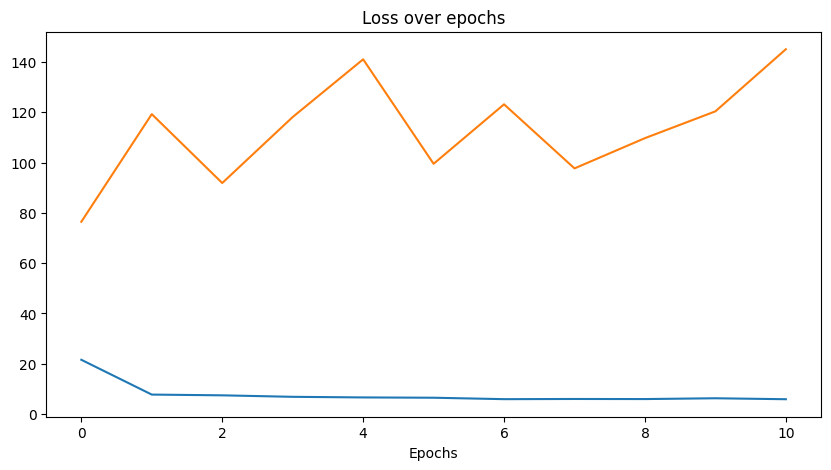

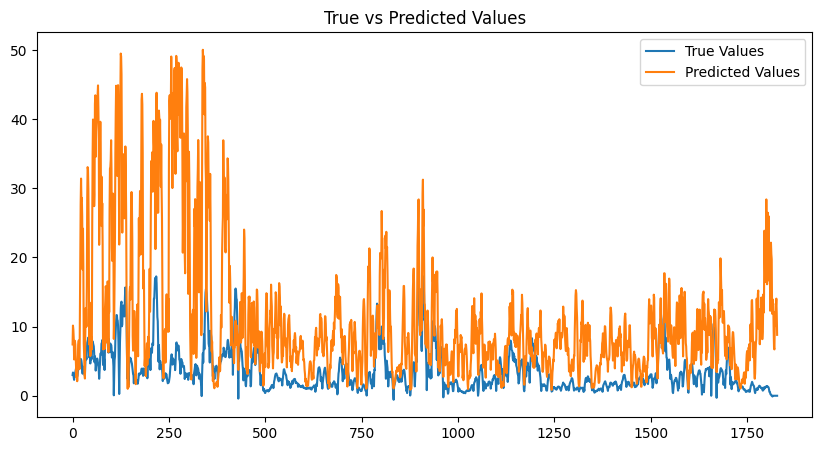

In [50]:
# Exchange for which model needs to be trained
exchange = 'coinbase'  # Change this to 'coinbase' or 'binance' as needed

# Train the model for the specific exchange
train_for_exchange(exchange)



Training model for binance exchange...
7


Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 1/100
Train Loss: 30.805040 | Test Loss: 9.216293
Epoch: 2/100
Train Loss: 24.461633 | Test Loss: 17.697603
Epoch: 3/100
Train Loss: 20.703387 | Test Loss: 33.850154
Epoch: 4/100
Train Loss: 14.936335 | Test Loss: 74.878819
Epoch: 5/100
Train Loss: 11.668902 | Test Loss: 125.438113
Epoch: 6/100
Train Loss: 10.299613 | Test Loss: 132.831416
Epoch: 7/100
Train Loss: 9.576001 | Test Loss: 112.246012
Epoch: 8/100
Train Loss: 9.006748 | Test Loss: 142.400854
Epoch: 9/100
Train Loss: 9.219977 | Test Loss: 153.951736
Epoch: 10/100
Train Loss: 8.684397 | Test Loss: 136.169906
Epoch: 11/100
Train Loss: 9.065185 | Test Loss: 143.806932
Early stopping
Final Train RMSE: 6.466728 | Final Test RMSE: 11.311371


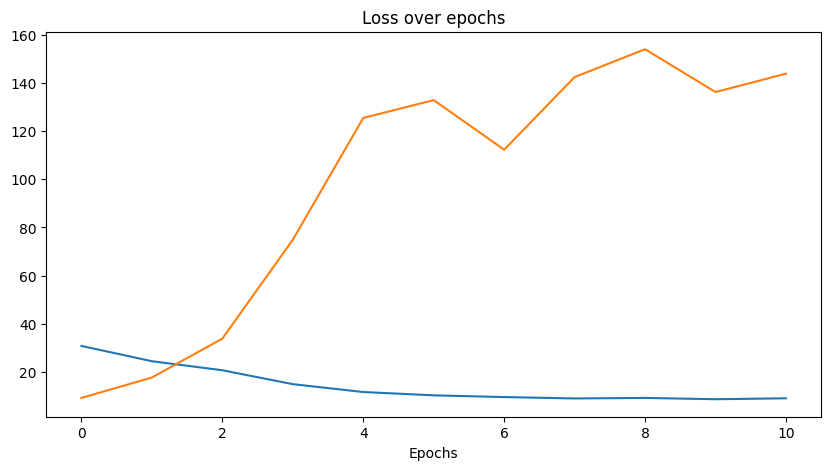

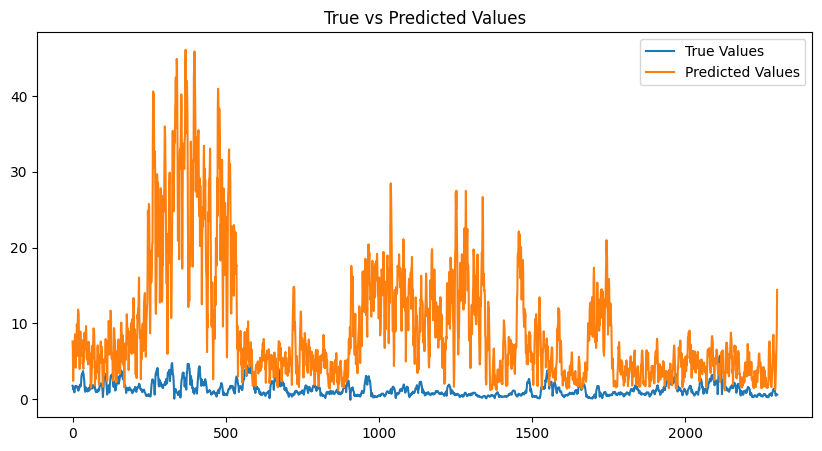

In [51]:
# Exchange for which model needs to be trained
exchange = 'binance'  # Change this to 'coinbase' or 'binance' as needed

# Train the model for the specific exchange
train_for_exchange(exchange)